In [55]:
import numpy as np
import time
from tqdm.notebook import tqdm,trange
import matplotlib.pyplot as plt
import scipy.stats

In [2]:
def gen_data(num_class = 4, num_dim = 2, num_object = 1000):
    mu = 20*np.random.rand(num_class,num_dim) - 10*np.random.rand(num_class,num_dim) # the prior for the mean
    
    sigma_ = 2*np.random.rand(num_class,num_dim) # sigma_ is used to initialize sigma
    sigma_[:,1] = sigma_[:,1]-0.5
    while ((sigma_[:,0]-np.abs(sigma_[:,1])) < 0).any(): # sigma has to be Positive semi-definite
        sigma_ = 2*np.random.rand(num_class,num_dim)
        sigma_[:,1] = sigma_[:,1]-0.5

    sigma = np.zeros((num_class,num_dim,num_dim)) 
    for i in range(num_class):
        sigma[i] = np.vstack((sigma_[i],sigma_[i][::-1]))

    c = np.random.choice(num_class, p = np.random.dirichlet(np.ones(num_class)), size = num_object) # the true class labels
    y = np.zeros((num_object, num_dim)) # the observations
    
    for i in range(num_class):
        idx = c==i
        y[idx,:] = np.random.multivariate_normal(mu[i], sigma[i], size = idx.sum())
    return y, c, mu, sigma

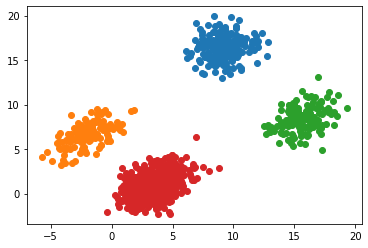

In [7]:
num_class = 4
num_dim = 2
num_object = 1000

y, c_groundtruth, mu_groundtruth, sigma_groundtruth = gen_data()
for i in range(num_class):
    idx = c_groundtruth==i
    plt.scatter(y[idx,0], y[idx,1])

In [89]:
n_k_groundtruth = np.zeros(num_class)
for i in range(num_class):
    n_k_groundtruth[i] = (c_groundtruth==i).sum()
n_k_groundtruth

array([186., 132., 150., 532.])

In [92]:
def gibbs(y, alpha=0.01, sigma_0=9, sigma_y=1, num_iter = 1000):
    num_object, num_dim= y.shape
    
    # initialize
    mu_0 = np.zeros(num_dim)
    sigma_0 = sigma_0*np.diag(np.ones(num_dim))
    sigma_y = sigma_y*np.diag(np.ones(num_dim))
    z = np.zeros(num_object,dtype = int)  # save the label for each data, all data are initialized in the class 0
    Nclust = int(z.max()+1)
    n_k = np.zeros(Nclust) # save the counts in each class
    for i in range(Nclust):
        n_k[i] = (z==i).sum()
    tau_0 = np.linalg.inv(sigma_0) # precision
    tau_y = np.linalg.inv(sigma_y)
    
    # start iteration
    result = np.zeros((num_iter, num_object)) # save z in each iteration
    for iter in trange(num_iter):
        for i in range(num_object):
            c_i = z[i]
            n_k[c_i] = n_k[c_i]-1
            if n_k[c_i] == 0: # remove the cluster if it is empty
                n_k[c_i] = n_k[Nclust-1]
                z[z==Nclust-1] = c_i
                n_k = n_k[:-1]
                Nclust = Nclust - 1
            z[i] = -1
            logp = np.zeros(Nclust+1)
            for c_i in range(Nclust): # currently, parameters of all classes are update. Can somehow accelerate here
                tau_p = tau_0 + n_k[c_i] * tau_y
                sigma_p = np.linalg.inv(tau_p)
                summ = y[z==c_i].sum(axis=0)
                mean_p = np.matmul(sigma_p, (np.matmul(tau_y, summ) + np.matmul(tau_0, mu_0) ))
                logp[c_i] = np.log(n_k[c_i]) + np.log(scipy.stats.multivariate_normal.pdf(y[i], mean_p, sigma_p + sigma_y))
            logp[Nclust] = np.log(alpha) + np.log(scipy.stats.multivariate_normal.pdf(y[i], mu_0, sigma_0 + sigma_y)) # probability of choose a new class
            max_logp = np.max(logp)
            logp = logp - max_logp
            loc_probs = np.exp(logp)
            loc_probs = loc_probs/np.sum(loc_probs)
            newz = np.random.choice(Nclust+1, p = loc_probs)
            if newz == Nclust: # add new class if needed
                n_k = np.hstack((n_k, 0))
                Nclust = Nclust + 1
            z[i] = newz
            n_k[newz] = n_k[newz] + 1
        result[iter,:] = z # save the labels into result
    return result

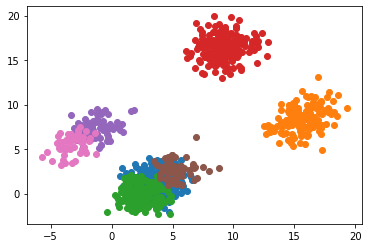

In [90]:
result = gibbs(y, alpha=0.01, sigma_0=9, sigma_y=1, num_iter = 1000)
z = result[-1] # pick the label in the last iteration

Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
    
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [127]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result[-1-i]-result[-2-i]).nonzero()[0].shape[0] / num_object)

0.141
0.162
0.163
0.158
0.176


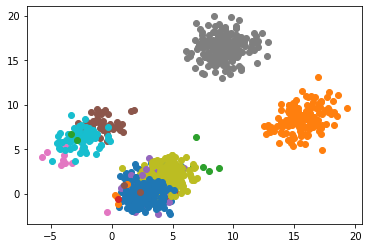

In [95]:
result2 = gibbs(y, alpha=5, sigma_0=9, sigma_y=1, num_iter = 1000)
z = result2[-1]
Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [128]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result2[-1-i]-result2[-2-i]).nonzero()[0].shape[0] / num_object)

0.292
0.288
0.288
0.318
0.314


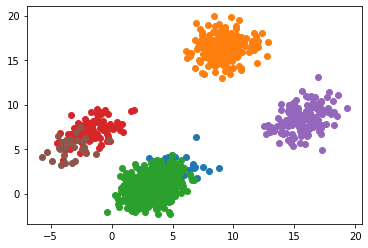

In [96]:
result3 = gibbs(y, alpha=0.01, sigma_0=9, sigma_y=2, num_iter = 1000)
z = result3[-1]
Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [129]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result3[-1-i]-result3[-2-i]).nonzero()[0].shape[0] / num_object)

0.114
0.121
0.118
0.116
0.098


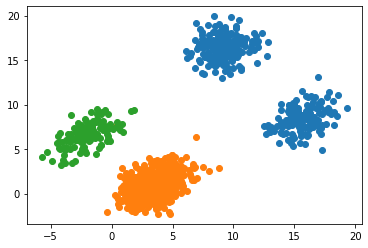

In [97]:
result4 = gibbs(y, alpha=0.01, sigma_0=9, sigma_y=4, num_iter = 1000)
z = result4[-1]
Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [130]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result4[-1-i]-result4[-2-i]).nonzero()[0].shape[0] / num_object)

0.001
0.003
0.002
0.002
0.002


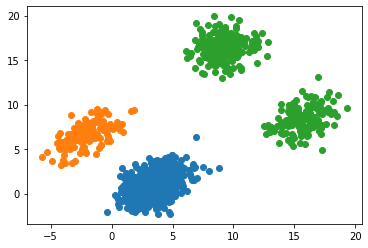

In [98]:
result5 = gibbs(y, alpha=0.01, sigma_0=9, sigma_y=3, num_iter = 1000)
z = result5[-1]
Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [131]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result5[-1-i]-result5[-2-i]).nonzero()[0].shape[0] / num_object)

0.001
0.002
0.001
0.0
0.0


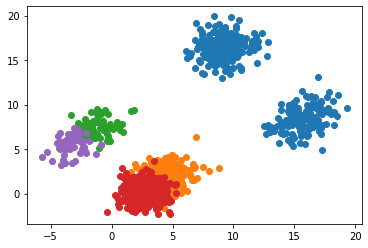

In [99]:
result6 = gibbs(y, alpha=0.01, sigma_0=1, sigma_y=1, num_iter = 1000)
z = result6[-1]
Nclust = int(z.max()+1)
n_k = np.zeros(Nclust)
for i in range(Nclust):
    n_k[i] = (z==i).sum()
for i in range(Nclust):
    idx = z==i
    plt.scatter(y[idx,0], y[idx,1])

In [132]:
# show propotion of label changes in the last few iterations
for i in range(5):
    print((result6[-1-i]-result6[-2-i]).nonzero()[0].shape[0] / num_object)

0.114
0.113
0.097
0.109
0.12


In [140]:
# showing the labels of the first 10 data in the last 5 iteration
# some labels are switching back and forth
for i in range(5):
    print(result6[-1-i,:10])

[0. 3. 3. 3. 3. 1. 1. 3. 0. 1.]
[0. 3. 3. 1. 3. 1. 1. 3. 0. 1.]
[0. 3. 3. 3. 3. 3. 3. 3. 0. 1.]
[0. 3. 3. 3. 3. 1. 3. 3. 0. 1.]
[0. 3. 3. 3. 3. 1. 3. 3. 0. 1.]
